# In this notebook we will compare how log-transforming the neighborhood data impacts model performance
## To do this we will predict IFNg positivity in T cells. 
## We will use our typical pipeline of LASSO -> PLS and use sampling to ensure that group size is equal and look at the model residuals to assess the results

In [1]:
#### importing original data ####
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns 
import re 
%matplotlib inline
import glob
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#### Load processed data ####
#df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/neighbor_data/tumor_stroma/tumor_stroma_merged_neighbor_data.csv')
df.shape

(5307540, 135)

In [3]:
# remove all cells halo deems as 'glass' 

df = df.loc[df['ClassifierLabel'] != 'glass']


In [4]:
# create new variables: total number of neighbors defined as the total number of neighbors of each immune cell subset based on the sum of IFN+ and IFN- or the total number of cancer cell neighbors MHC+ and MHC-
# first tumor then stroma at 30 and 200 um

df['Total CD3+CD8+ Tumor Neighbors_30um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_30um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_30um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_30um'] = df['PanCyto+MHCI+ Tumor Neighbors_30um'] + df['PanCyto+MHCI- Tumor Neighbors_30um']

df['Total CD3+CD8+ Stroma Neighbors_30um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8+IFNy- Stroma Neighbors_30um']
df['Total CD3+CD8- Stroma Neighbors_30um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8-IFNy- Stroma Neighbors_30um']
df['Total CD56+CD3- Stroma Neighbors_30um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_30um'] + df['CD56+CD3-IFNy- Stroma Neighbors_30um']
df['Total PanCyto Stroma Neighbors_30um'] = df['PanCyto+MHCI+ Stroma Neighbors_30um'] + df['PanCyto+MHCI- Stroma Neighbors_30um']

df['Total CD3+CD8+ Tumor Neighbors_200um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_200um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_200um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_200um'] = df['PanCyto+MHCI+ Tumor Neighbors_200um'] + df['PanCyto+MHCI- Tumor Neighbors_200um']

df['Total CD3+CD8+ Stroma Neighbors_200um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8+IFNy- Stroma Neighbors_200um']
df['Total CD3+CD8- Stroma Neighbors_200um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8-IFNy- Stroma Neighbors_200um']
df['Total CD56+CD3- Stroma Neighbors_200um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_200um'] + df['CD56+CD3-IFNy- Stroma Neighbors_200um']
df['Total PanCyto Stroma Neighbors_200um'] = df['PanCyto+MHCI+ Stroma Neighbors_200um'] + df['PanCyto+MHCI- Stroma Neighbors_200um']


In [5]:
# define immune cells 
immune_cells = ['CD3+CD8+IFNy+',
       'CD3+CD8+IFNy-', 'CD3+CD8-IFNy+', 'CD3+CD8-IFNy-']

# define neighbor columns
    
neighbors = ['CD3+CD8+IFNy+ Tumor Neighbors_30um','CD3+CD8+IFNy+ Stroma Neighbors_30um','CD3+CD8+IFNy- Tumor Neighbors_30um','CD3+CD8+IFNy- Stroma Neighbors_30um',
             'CD3+CD8-IFNy+ Tumor Neighbors_30um','CD3+CD8-IFNy+ Stroma Neighbors_30um','CD3+CD8-IFNy- Tumor Neighbors_30um','CD3+CD8-IFNy- Stroma Neighbors_30um',
             'CD56+CD3-IFNy+ Tumor Neighbors_30um','CD56+CD3-IFNy+ Stroma Neighbors_30um','CD56+CD3-IFNy- Tumor Neighbors_30um','CD56+CD3-IFNy- Stroma Neighbors_30um',
             'PanCyto+MHCI+ Tumor Neighbors_30um','PanCyto+MHCI+ Stroma Neighbors_30um','PanCyto+MHCI- Tumor Neighbors_30um','PanCyto+MHCI- Stroma Neighbors_30um',  
             'CD3+CD8+IFNy+ Tumor Neighbors_200um','CD3+CD8+IFNy+ Stroma Neighbors_200um','CD3+CD8+IFNy- Tumor Neighbors_200um','CD3+CD8+IFNy- Stroma Neighbors_200um',
             'CD3+CD8-IFNy+ Tumor Neighbors_200um','CD3+CD8-IFNy+ Stroma Neighbors_200um','CD3+CD8-IFNy- Tumor Neighbors_200um','CD3+CD8-IFNy- Stroma Neighbors_200um',
             'CD56+CD3-IFNy+ Tumor Neighbors_200um','CD56+CD3-IFNy+ Stroma Neighbors_200um','CD56+CD3-IFNy- Tumor Neighbors_200um','CD56+CD3-IFNy- Stroma Neighbors_200um',
             'PanCyto+MHCI+ Tumor Neighbors_200um','PanCyto+MHCI+ Stroma Neighbors_200um','PanCyto+MHCI- Tumor Neighbors_200um','PanCyto+MHCI- Stroma Neighbors_200um','Total CD3+CD8+ Tumor Neighbors_30um',
             'Total CD3+CD8- Tumor Neighbors_30um','Total CD56+CD3- Tumor Neighbors_30um','Total CD3+CD8+ Stroma Neighbors_30um','Total CD3+CD8- Stroma Neighbors_30um','Total CD56+CD3- Stroma Neighbors_30um',
             'Total CD3+CD8+ Tumor Neighbors_200um','Total CD3+CD8- Tumor Neighbors_200um','Total CD56+CD3- Tumor Neighbors_200um','Total CD3+CD8+ Stroma Neighbors_200um','Total CD3+CD8- Stroma Neighbors_200um',
             'Total CD56+CD3- Stroma Neighbors_200um','Total PanCyto Tumor Neighbors_30um','Total PanCyto Stroma Neighbors_30um','Total PanCyto Tumor Neighbors_200um','Total PanCyto Stroma Neighbors_200um']

In [6]:
# select just the immune cells
df_immune = df[df[immune_cells].any(axis=1)]
df_immune;

# First lets use the raw data (not log transformed)

In [7]:
# LASSO to reduce identify key variables


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats
from scipy.stats import zscore 

X_unscaled = df_immune[neighbors]
#X = np.log1p(X_unscaled) 
y_str = df_immune['IFNy']
#X = stats.zscore(X_unscaled, ddof = 0)
y = y_str.apply(lambda x: 1 if x > 0 else -1)
y

\


# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X_unscaled,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X_unscaled.columns)[lasso_feat != 0]
lasso_selected_x = X_unscaled.loc[:,X_unscaled.columns.isin(selected_features)]

# warnings can be supressed by increasing n_iter



/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 795.0885057799278, tolerance: 3.5431664450746556
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 426.6915560435955, tolerance: 2.3162868812782853
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1723.7755022837018, tolerance: 2.3162868812782853
  model = cd_fast.enet_coordinate_descent_gram(


In [8]:
# print the alpha strength and number of variables selected
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.1 8


In [9]:
# subset df to just variables selected by lasso

X_unscaled = df_immune[neighbors]
#X = np.log1p(X_unscaled) 
y_str = df_immune['IFNy']
X_unscaled = X_unscaled.loc[:,X_unscaled.columns.isin(selected_features)]
#X = stats.zscore(X_unscaled, ddof = 0)
#y = y_str.apply(lambda x: 1 if x > 0 else -1)
y= y_str
df= pd.concat([X_unscaled, y], axis = 1)

sampled_df = df.sample(n=25000, random_state=42)
sampled_X = sampled_df.iloc[:,:-1]
sampled_y = sampled_df.iloc[:,-1]
X=sampled_X
y = sampled_y

In [10]:
df

,CD3+CD8+IFNy+ Tumor Neighbors_200um,CD3+CD8+IFNy- Tumor Neighbors_200um,CD3+CD8+IFNy- Stroma Neighbors_200um,CD3+CD8-IFNy- Tumor Neighbors_200um,CD3+CD8-IFNy- Stroma Neighbors_200um,CD56+CD3-IFNy- Stroma Neighbors_200um,PanCyto+MHCI+ Tumor Neighbors_200um,PanCyto+MHCI- Tumor Neighbors_200um,IFNy
176,0.0,3.0,0.0,8.0,4.0,0.0,14.0,90.0,0.0
179,0.0,4.0,0.0,7.0,4.0,0.0,16.0,102.0,0.0
182,0.0,5.0,0.0,8.0,4.0,0.0,18.0,124.0,0.0
188,0.0,12.0,0.0,13.0,6.0,0.0,34.0,220.0,0.0
192,0.0,12.0,0.0,13.0,8.0,0.0,42.0,236.0,0.0
...,...,...,...,...,...,...,...,...,...
5307503,0.0,3.0,1.0,4.0,5.0,0.0,21.0,239.0,0.0
5307505,0.0,3.0,0.0,4.0,6.0,0.0,21.0,269.0,0.0
5307515,0.0,2.0,0.0,14.0,1.0,0.0,15.0,241.0,0.0
5307518,0.0,2.0,0.0,15.0,1.0,0.0,16.0,233.0,0.0


100%|██████████| 1000/1000 [00:11<00:00, 84.80it/s]


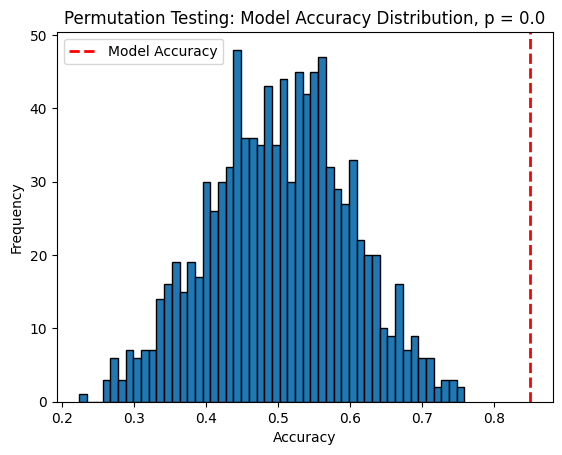

In [11]:
# build model with lasso selected features
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)

X_unscaled = df_immune[neighbors]
#X = np.log1p(X_unscaled) 
y_str = df_immune['IFNy']
X_unscaled = X_unscaled.loc[:,X_unscaled.columns.isin(selected_features)]
#X = stats.zscore(X_unscaled, ddof = 0)
#y = y_str.apply(lambda x: 1 if x > 0 else -1)
y_str = df_immune['IFNy'].map({0.0: -1, 1.0: 1})
y= y_str
df = pd.concat([X_unscaled, y_str], axis=1)
df.columns = list(X_unscaled.columns) + ['IFNy']

# Split by class
class_0 = df[df['IFNy'] == -1].sample(n=1200, random_state=42)
class_1 = df[df['IFNy'] == 1].sample(n=1200, random_state=42)

# Concatenate and shuffle
sampled_df = pd.concat([class_0, class_1]).sample(frac=1, random_state=42)

# Split into features and labels
sampled_X = sampled_df.iloc[:, :-1]
sampled_y = sampled_df['IFNy']

X = sampled_X
y = sampled_y



# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {round(p, 3)}')
plt.legend()
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/figS6a.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

<Figure size 800x600 with 0 Axes>

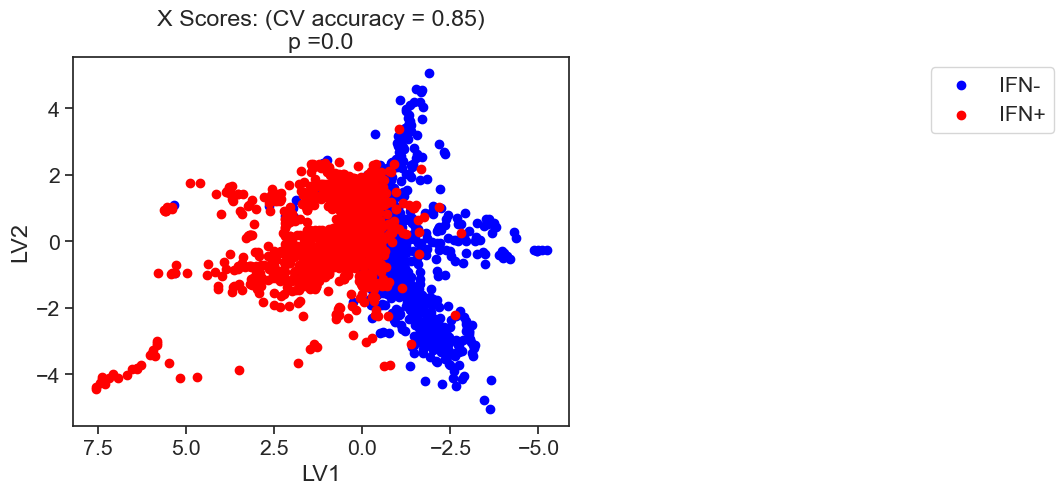

In [12]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho']) 
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(8, 6)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
fig, ax = plt.subplots()
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='IFN-')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='IFN+')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (2,1))
ax.invert_xaxis()
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6c.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

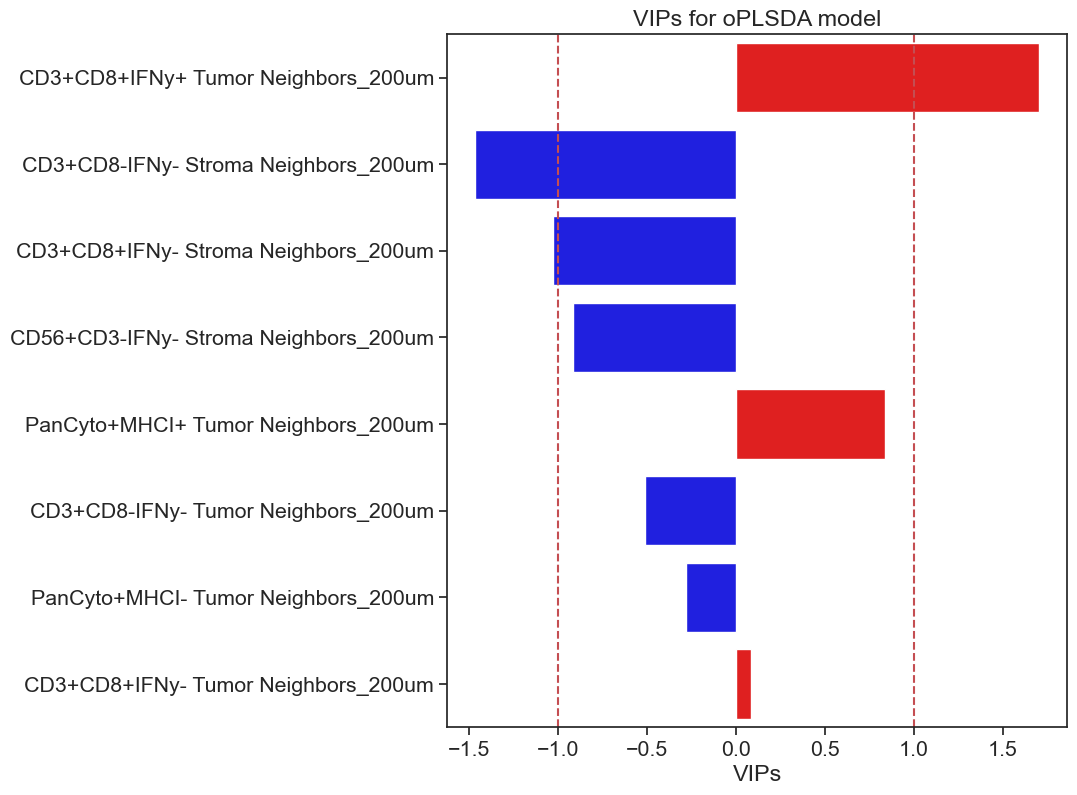

In [13]:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 9)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] < 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6d_old_names.pdf', format = 'pdf', bbox_inches = 'tight')

plt.title('VIPs for oPLSDA model')

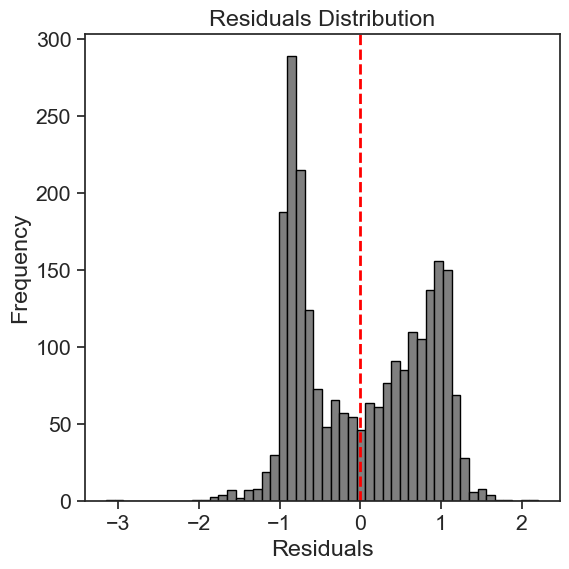

In [14]:
# Calculate residuals
residuals = y - processed_y_pred
plt.figure(figsize=(6, 6))

# Create the histogram for residuals
plt.hist(residuals, bins=50, edgecolor='black', color='tab:grey')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Line at x=0 for reference
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Save the figure as a PDF file
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure0/residuals_non_log.pdf', format='pdf')

# Show the plot
plt.show()

# now log scale the data and repeat the process

In [15]:
# reload data and scale then do lasso to select features
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats
from scipy.stats import zscore 

X_unscaled = df_immune[neighbors]
#X = np.log1p(X_unscaled) 
y_str = df_immune['IFNy']
#X = stats.zscore(X_unscaled, ddof = 0)
y_str = df_immune['IFNy'].map({0.0: -1, 1.0: 1})

y = y_str.apply(lambda x: 1 if x > 0 else -1)
y
X = np.log1p(X_unscaled)


#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]

# warnings can be supressed by increasing n_iter

/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405.81706171754195, tolerance: 3.5551986368596507
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8155.976499623306, tolerance: 3.5551986368596507
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10954.191339184597, tolerance: 3.5551986368596507
  model = cd_fast.enet_coordinate_descent_gram(
/home/gh8sj/.conda/envs/spy_cell

100%|██████████| 1000/1000 [00:19<00:00, 52.14it/s]


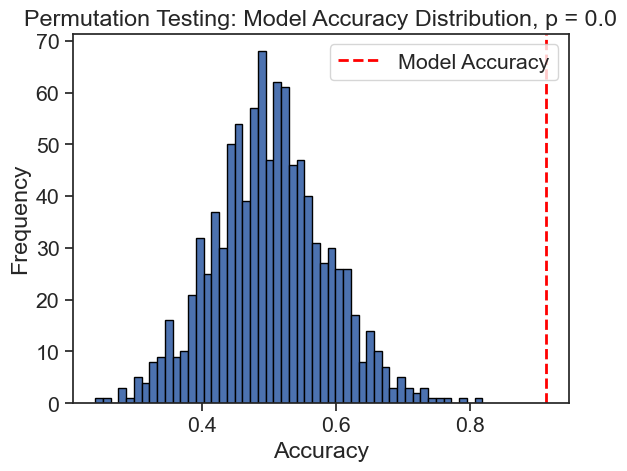

In [16]:
# build model with lasso selected features and print permutation testing 

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)

X_unscaled = df_immune[neighbors]

X = np.log1p(X_unscaled) 
y_str = df_immune['IFNy']
X = X.loc[:,X.columns.isin(selected_features)]
#X = stats.zscore(X_unscaled, ddof = 0)
#y = y_str.apply(lambda x: 1 if x > 0 else -1)
y_str = df_immune['IFNy'].map({0.0: -1, 1.0: 1})
y= y_str
df = pd.concat([X, y_str], axis=1)
df.columns = list(X.columns) + ['IFNy']

# Split by class
class_0 = df[df['IFNy'] == -1].sample(n=1200, random_state=42)
class_1 = df[df['IFNy'] == 1].sample(n=1200, random_state=42)

# Concatenate and shuffle
sampled_df = pd.concat([class_0, class_1]).sample(frac=1, random_state=42)

# Split into features and labels
sampled_X = sampled_df.iloc[:, :-1]
sampled_y = sampled_df['IFNy']

X = sampled_X
y = sampled_y



# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {round(p, 3)}')
plt.legend()
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/figS6a.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

<Figure size 800x600 with 0 Axes>

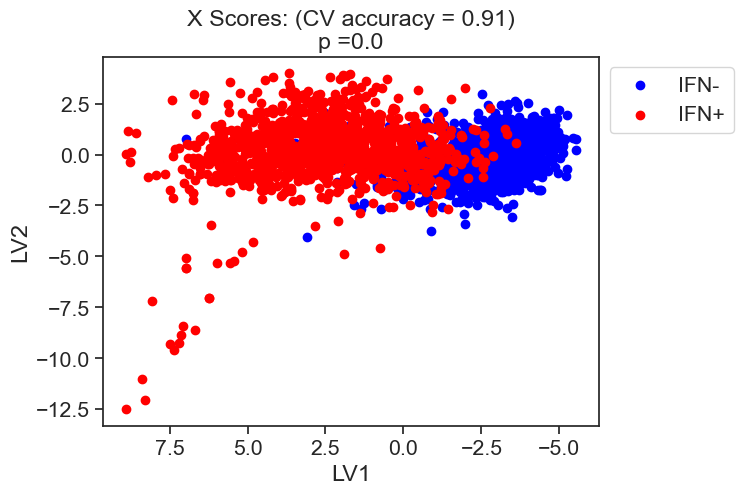

In [17]:
# X scores plot
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(8, 6)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
fig, ax = plt.subplots()
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='IFN-')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='IFN+')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
ax.invert_xaxis()
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6c.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

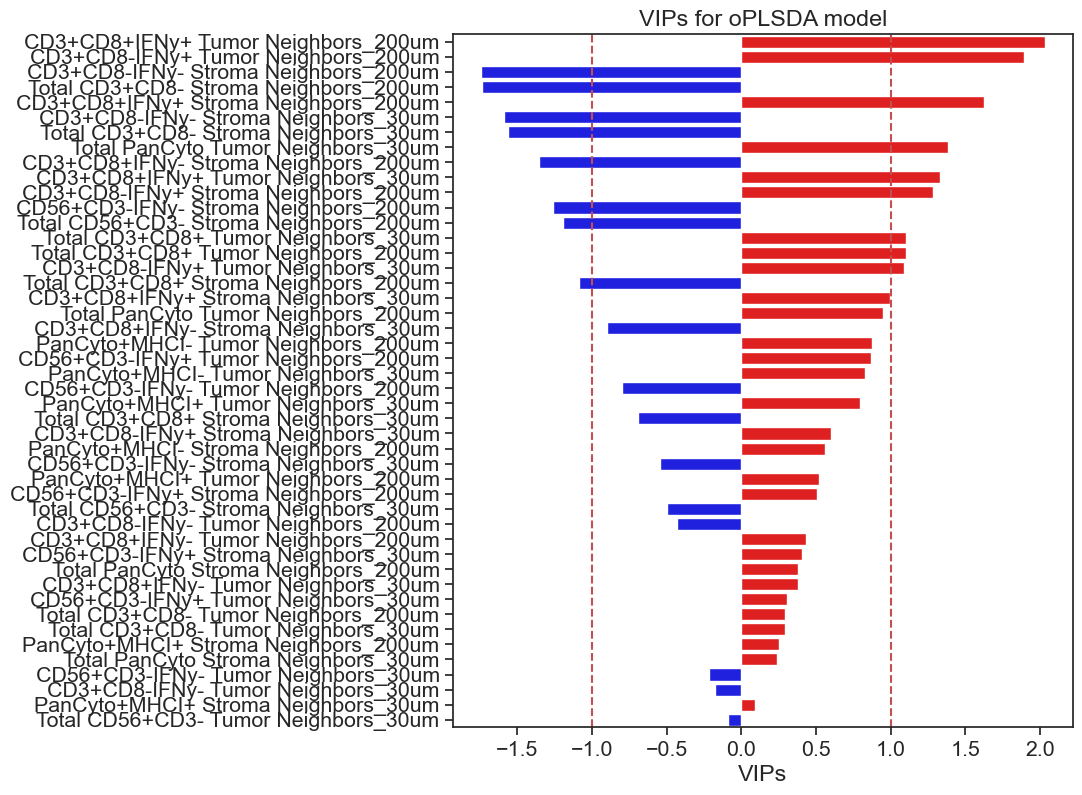

In [18]:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 9)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] < 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6d_old_names.pdf', format = 'pdf', bbox_inches = 'tight')

plt.title('VIPs for oPLSDA model')

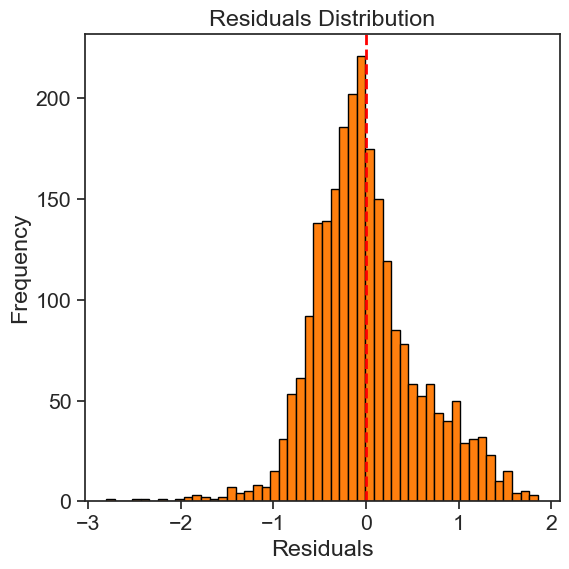

In [19]:
# Calculate and plot residuals
residuals = y - processed_y_pred

plt.figure(figsize=(6, 6))

# Create the histogram for residuals
plt.hist(residuals, bins=50, edgecolor='black', color='tab:orange')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Line at x=0 for reference
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Save the figure as a PDF file
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure0/residuals_log.pdf', format='pdf')

# Show the plot
plt.show()